
# Sistemas Inteligentes 2021-I
## Proyecto Final: Trip Advisor Hotel Reviews
### Integrantes: Juan Sebastián Vargas, Juan Montoya, David Eslava

TripAdvisor es una paltaforma web desarrollada en EE.UU la cual brinda reseñas de contenido, recomendaciones, indexado y foros para hoteles, viajes y restaurantes en muchos sitios alrededor del mundo.  
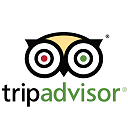  
Creada en Febrero del 2000 por por Stephen Kaufer, Langley Steinert, TripAdvisor se posiciona en una buena reputación dentro de los usuarios sienod uno de los sitios preferidos por los turistas a la hora de reservar y consultar distintos hoteles, viajes y restaurantes en el lugar de destino.  
TripAdvisor es una paltaforma en la cual los usuarios retroalimentan la información de los diferentes sitios que visitan aa traves de las reseñas que bridan, esta métrica permite tanto a los viajeros fijarse en determinados sitios de itneres según las recomendaciones y calidad de servicio, como para las empresas que brindan sus servicios los cuales les permite ganarse una reputación, darse a conocer y también mejorar constantemente el servicio según las opiniones que dan los turistas.  
Enfocandonos en esta métrica y exclusivamente al sector hotelero, TripAdvisor mide la calidad de estos sitios según las opiniones de sus visitantes, permitiendo hacer un comentario y dando una calificación de 1 a 5 estrellas en donde 5 estrellas es considerado un excelente servicio, y 1 estrella la peor calificación e inconformidad con el sitio.  
Tanto para la plataforma como para los hoteleros, es importante identificar que factores influyen en los clientes a la hora de calificar el servicio. Así como también que características son comunes dentro de cada una de las calificaciones.  
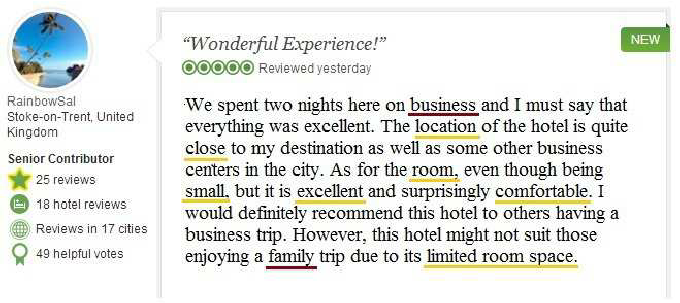

El objetivo de este proyecto es poder crear un sistema inteligente (Red neuronal) que pueda determinar las características principales de las reseñas que se tienen de los hoteles para uno de los 5 rangos de calificación posibles (1 estrellas, 2 estrellas, 3 estrellas, 4 estrellas y 5 estrellas)

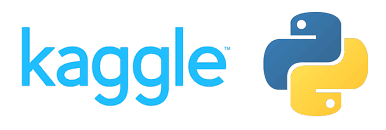

Para poder obtener dicha información, se hace provecho de **Kaggle** un sitio web que facilita la busqueda de información la cual está organizada y preparada para hacer ciencia de datos.  
Para realizar el modelo, se extrae el siguiente [dataset](https://www.kaggle.com/andrewmvd/trip-advisor-hotel-reviews)  el cual contiene la información de 20000 reseñas de hoteles junto con su respectiva calificación.


Pero antes que nada, se inicia la implementación importando las librerías necesarias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator #to generate cloud words
import string
from urllib.request import urlretrieve #to download from url 
import os
import csv
from tqdm import tqdm #bar progress
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from keras import layers, models

## 1.   Preparación de los datos
Primero se descargar el archivo y se leen los datos.  


In [2]:
if not os.path.isfile('tripadvisor_hotel_reviews.csv'):
    print("Downloading movie simple text file")
    conceptnet_url = 'https://raw.githubusercontent.com/jsmontoyaco/Sistemas-Inteligentes-Proyecto-Final/main/tripadvisor_hotel_reviews.csv'
    urlretrieve(conceptnet_url, 'tripadvisor_hotel_reviews.csv')

In [3]:
remove_punct=str.maketrans('','',string.punctuation)
ws = [] 
ys = [] 
cw = []
with open("tripadvisor_hotel_reviews.csv", mode="r", encoding='utf-8', errors='ignore') as f:
  f = csv.reader(f, delimiter=',')
  for l in tqdm(f):
    words = l[0].translate(remove_punct).lower().split()
    cw.append(l[0].translate(remove_punct).lower())
    y = int(l[1])
    ws.append(words)
    ys.append(y)
  
ys = np.array(ys)
cw = np.array(cw)

20491it [00:00, 24018.74it/s]


In [4]:
print(ws[0:5])
print(ys[0:5])
print(cw[0:5])

[['nice', 'hotel', 'expensive', 'parking', 'got', 'good', 'deal', 'stay', 'hotel', 'anniversary', 'arrived', 'late', 'evening', 'took', 'advice', 'previous', 'reviews', 'did', 'valet', 'parking', 'check', 'quick', 'easy', 'little', 'disappointed', 'nonexistent', 'view', 'room', 'room', 'clean', 'nice', 'size', 'bed', 'comfortable', 'woke', 'stiff', 'neck', 'high', 'pillows', 'not', 'soundproof', 'like', 'heard', 'music', 'room', 'night', 'morning', 'loud', 'bangs', 'doors', 'opening', 'closing', 'hear', 'people', 'talking', 'hallway', 'maybe', 'just', 'noisy', 'neighbors', 'aveda', 'bath', 'products', 'nice', 'did', 'not', 'goldfish', 'stay', 'nice', 'touch', 'taken', 'advantage', 'staying', 'longer', 'location', 'great', 'walking', 'distance', 'shopping', 'overall', 'nice', 'experience', 'having', 'pay', '40', 'parking', 'night'], ['ok', 'nothing', 'special', 'charge', 'diamond', 'member', 'hilton', 'decided', 'chain', 'shot', '20th', 'anniversary', 'seattle', 'start', 'booked', 'suit

## 2.  Análisis de Datos
Analicemos los datos de las reseñas, analizando la cantidad y proporción de cada calificación con respecto a las reseñas totales

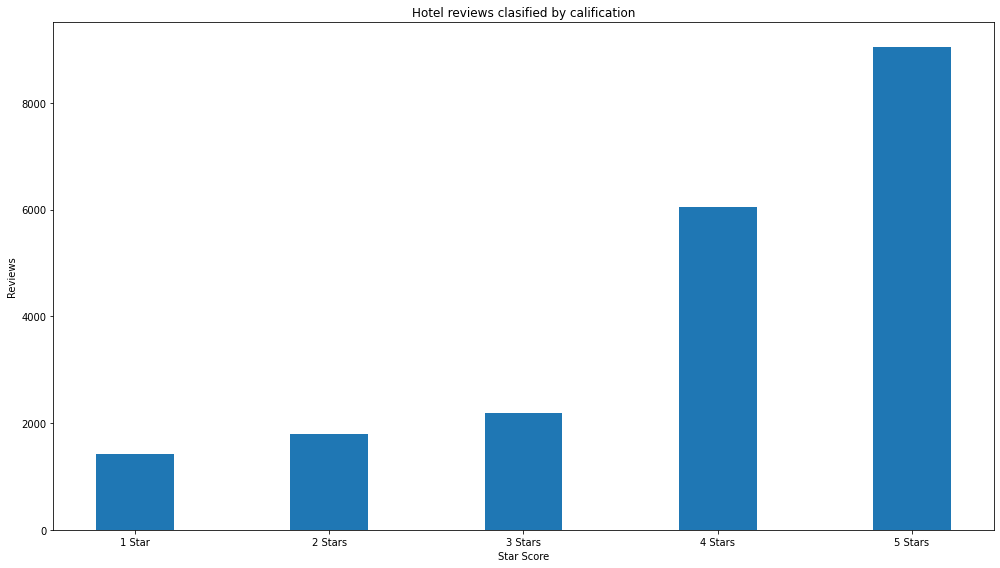

In [5]:
labels=['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars']
x = np.arange(len(labels))+1
plotdata = np.bincount(np.array(ys))[1:]
fig, ax = plt.subplots(figsize=(14,8))
ax.bar(x, plotdata, width=0.4)
ax.set_ylabel('Reviews')
ax.set_xlabel('Star Score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title('Hotel reviews clasified by calification')
fig.tight_layout()
plt.show()

Mirando la distribución porcentual

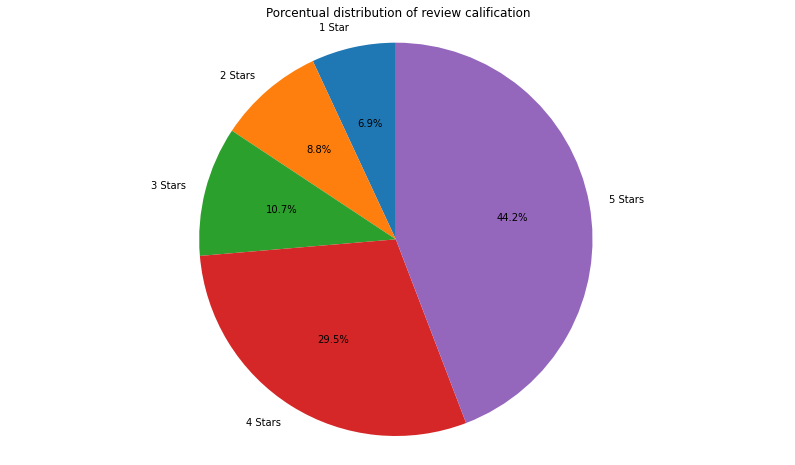

In [6]:
sizes = plotdata/sum(plotdata) *100
explode = (0,0,0,0,0)
fig2, ax2 = plt.subplots(figsize=(14,8))
ax2.pie(sizes, explode= explode, labels= labels, autopct='%1.1f%%', startangle=90)
ax2.axis('equal')
ax2.set_title('Porcentual distribution of review calification')
plt.show()

Como podemos ver, tenemos que en general más de la mitad de las calificaciones dadas por los usuarios son "buenas" estándo en el rango de 4 a 5 estrellas

Ahora el siguiente objetivo es ver que palabras son frecuentes dentro de las reseñas según su calificación, usando las herramientas gráficas de python se puede hacer una nube de palabras como mejor representación gráfica de la información.

In [7]:
words1s = np.take(cw, np.argwhere(ys==1))
strw1 = ' '.join(str(i) for i in words1s)
words2s = np.take(cw, np.argwhere(ys==2))
strw2 = ' '.join(str(i) for i in words2s)
words3s = np.take(cw, np.argwhere(ys==3))
strw3 = ' '.join(str(i) for i in words3s)
words4s = np.take(cw, np.argwhere(ys==4))
strw4 = ' '.join(str(i) for i in words4s)
words5s = np.take(cw, np.argwhere(ys==5))
strw5 = ' '.join(str(i) for i in words5s)

In [8]:
def cloudwordplot(cloudword, calification):
  # Create and generate a word cloud image:
  wordcloud = WordCloud(width=1400, height=800, contour_color='white', background_color='white').generate(cloudword)

  # Display the generated image:
  plt.figure(figsize=(14,8))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.title('Palabras más comunes en las reseñas de %1d estrellas' %(calification))
  plt.axis("off")
  plt.show()
 

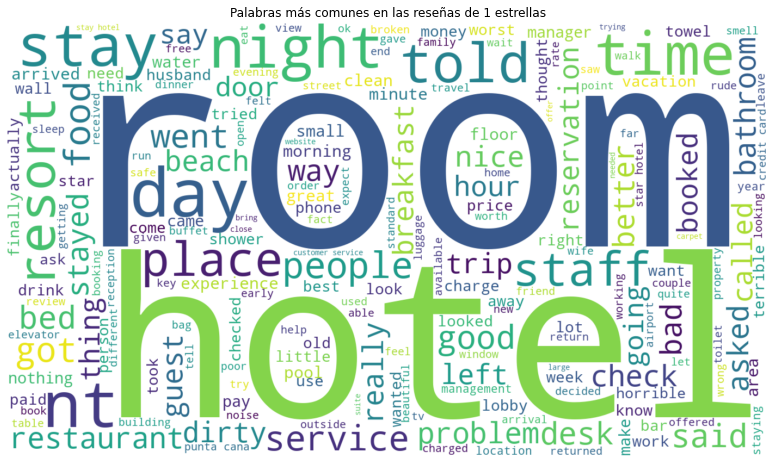

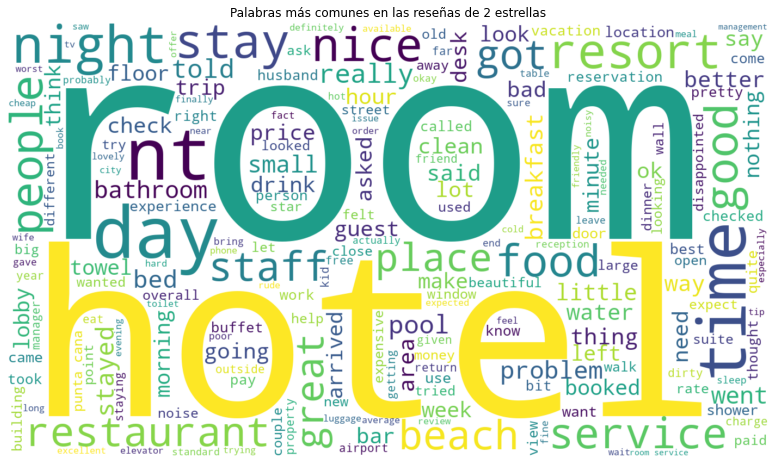

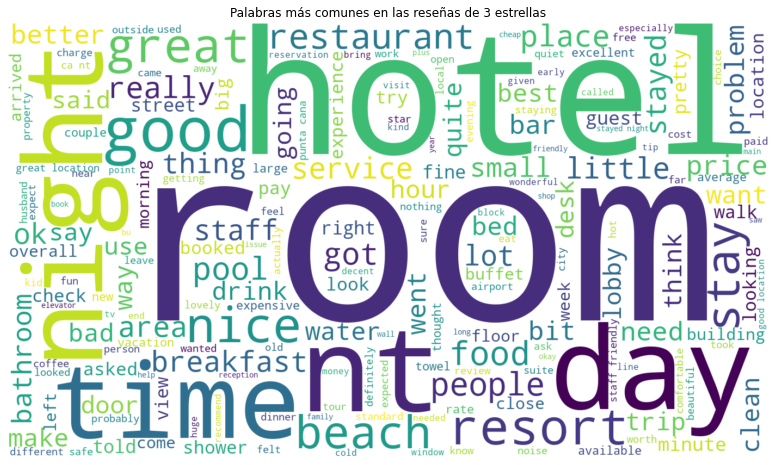

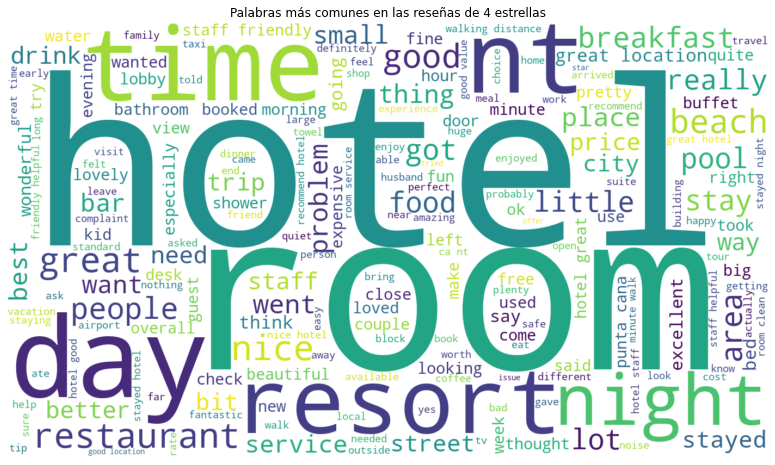

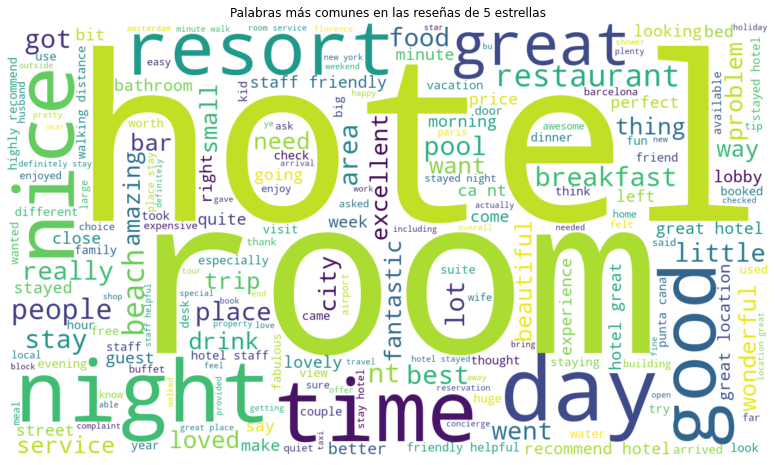

In [9]:
cloudwordplot(strw1,1)
cloudwordplot(strw2,2)
cloudwordplot(strw3,3)
cloudwordplot(strw4,4)
cloudwordplot(strw5,5)

## 3.  Modelamiento
El objetivo es poder predecir con base a una reseña, su respectiva calificación, este tipo de modelos es útil cuando no se tienen los datos eiquetados. Por ejemplo, comentarios en redes sociales los cuales no tienen eiqueta de calificación.  
Para ello se plantea un modelo de red neuronal para el procesamiento de texto, en donde nuestros datos X (features) serán las reseñas y la salida o etiqueta (y, labels) será la calificación [Review, Rating].  

### 3.1 Creación y preentrenamiento del vocabulario de palabras

Para poder realizar la predicción de datos con una red neuronal, se requiere que las palabras sean vectorizadas, es decir, tranformar la palabra en un espacio vectorial con $m$ dimensiones, aquellas palabras que se encuentren vectorialmente cerca nos indicarán que hay cierta similitud o correlación entre ellas. Aquella herramienta que nos permite asignar ese espacio vectorial se conoce como vocabulario o  Word embeddings. Se puede encontrar varios tipos de vocabualrios preentrenados y enfocados para distintos entornos. En este caso, usando las herramientas de Scikitlearn, podemos prentrenar un vocabulario con base en el conjunto de datos.

In [12]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv', header= None, names=['Review', 'Rating'])
df.shape

(20491, 2)

### Función para procesar el texto, respecto a comas, signos de exclmación, etc.

In [14]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords_list = set(stopwords.words('english'))

punctuations = """!()-![]{};:,+'"\,<>./?@#$%^&*_~Â""" #List of punctuation to remove

def reviewParse(review):
    splitReview = review.split() # Split the review into words
    parsedReview = " ".join([word.translate(str.maketrans('', '', punctuations)) + " " for word in splitReview]) #Takes the stubborn punctuation out
    return parsedReview # Returns the parsed review
  
def clean_review(review):
    clean_words = []
    splitReview = review.split()
    for w in splitReview:
        if w.isalpha() and w not in stopwords_list:
            clean_words.append(w.lower())
    clean_review = " ".join(clean_words)
    return clean_review

df["Review"] = df["Review"].apply(reviewParse).apply(clean_review) #Parse all the reviews for their punctuation and add it into a new column

df.head() #Take a peek at the dataset

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms experience hotel monaco seattle goo...,3
3,unique great stay wonderful time hotel monaco ...,5
4,great stay great stay went seahawk game awesom...,5


Vectorizamos

In [15]:
docs = list(df['Review'])[:9000]
print(len(docs))

9000


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer 

tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features = 20000) 
 
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(docs)

Tomamos 9.000 muestras del dataset.

In [17]:
X = tfidf_vectorizer_vectors.toarray()
Y = df['Rating'][:9000]

Muestra del vocabulario

In [18]:
tfidf_vectorizer.vocabulary_

{'nice': 10575,
 'hotel': 7678,
 'expensive': 5682,
 'parking': 11649,
 'got': 6894,
 'good': 6856,
 'deal': 4118,
 'stay': 16526,
 'anniversary': 602,
 'arrived': 863,
 'late': 8918,
 'evening': 5506,
 'took': 17645,
 'advice': 240,
 'previous': 13107,
 'reviews': 14704,
 'valet': 18432,
 'check': 2767,
 'quick': 13600,
 'easy': 5074,
 'little': 9205,
 'disappointed': 4552,
 'nonexistent': 10693,
 'view': 18568,
 'room': 14904,
 'clean': 2992,
 'size': 15853,
 'bed': 1457,
 'comfortable': 3215,
 'woke': 19517,
 'stiff': 16594,
 'neck': 10482,
 'high': 7455,
 'pillows': 12252,
 'soundproof': 16188,
 'like': 9125,
 'heard': 7333,
 'music': 10383,
 'night': 10607,
 'morning': 10254,
 'loud': 9350,
 'doors': 4795,
 'opening': 11032,
 'closing': 3064,
 'hear': 7331,
 'people': 12063,
 'talking': 17118,
 'hallway': 7176,
 'maybe': 9768,
 'noisy': 10676,
 'neighbors': 10517,
 'aveda': 1081,
 'bath': 1351,
 'products': 13315,
 'goldfish': 6845,
 'touch': 17699,
 'taken': 17103,
 'advantage': 

In [19]:
tfidf_vectorizer.vocabulary_

{'nice': 10575,
 'hotel': 7678,
 'expensive': 5682,
 'parking': 11649,
 'got': 6894,
 'good': 6856,
 'deal': 4118,
 'stay': 16526,
 'anniversary': 602,
 'arrived': 863,
 'late': 8918,
 'evening': 5506,
 'took': 17645,
 'advice': 240,
 'previous': 13107,
 'reviews': 14704,
 'valet': 18432,
 'check': 2767,
 'quick': 13600,
 'easy': 5074,
 'little': 9205,
 'disappointed': 4552,
 'nonexistent': 10693,
 'view': 18568,
 'room': 14904,
 'clean': 2992,
 'size': 15853,
 'bed': 1457,
 'comfortable': 3215,
 'woke': 19517,
 'stiff': 16594,
 'neck': 10482,
 'high': 7455,
 'pillows': 12252,
 'soundproof': 16188,
 'like': 9125,
 'heard': 7333,
 'music': 10383,
 'night': 10607,
 'morning': 10254,
 'loud': 9350,
 'doors': 4795,
 'opening': 11032,
 'closing': 3064,
 'hear': 7331,
 'people': 12063,
 'talking': 17118,
 'hallway': 7176,
 'maybe': 9768,
 'noisy': 10676,
 'neighbors': 10517,
 'aveda': 1081,
 'bath': 1351,
 'products': 13315,
 'goldfish': 6845,
 'touch': 17699,
 'taken': 17103,
 'advantage': 

División de datos

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, classification_report, roc_auc_score,roc_curve,auc

SEED = 224
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=SEED, stratify=Y)

###  3.2  Creación del modelo

In [21]:
lr = LogisticRegression()

In [22]:
lr.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
lr.score(X_test, y_test)

0.5761111111111111

Predicción

In [24]:
y_pred = lr.predict(X_test)

### Análisis

In [25]:
from sklearn.metrics import confusion_matrix


confusion_matrix(y_pred,y_test)

array([[ 84,  27,   8,   1,   2],
       [ 28,  39,  25,  10,   0],
       [  6,  20,  24,  14,   0],
       [ 10,  43,  99, 285, 152],
       [ 13,  39,  41, 225, 605]])

In [26]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           1       0.60      0.69      0.64       122
           2       0.23      0.38      0.29       102
           3       0.12      0.38      0.18        64
           4       0.53      0.48      0.51       589
           5       0.80      0.66      0.72       923

    accuracy                           0.58      1800
   macro avg       0.46      0.52      0.47      1800
weighted avg       0.64      0.58      0.60      1800





---



---


***Red Neuronal***

Es importante tener en cuenta las dimensiones en nuestros datos. La red neuronal hará multiplicaciones de matrices en simultáneo y se debe tener explícito el número de datos que entran y el número que salen.

In [27]:
X_train.shape

(7200, 20000)

In [28]:
y_train.shape

(7200,)

Categorizando Y

In [29]:
from keras.utils.np_utils import to_categorical
from keras import regularizers

y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

Ejemplo

In [30]:
print(y_train[4302])
print('----------')
print(y_train_categorical[0])

5
----------
[0. 0. 0. 0. 0. 1.]


**Modelo Red Neuronal**

In [31]:
model = models.Sequential()
model.add(layers.Dense(48, activation='relu', input_shape=(20000,), kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dense(48, activation='relu', kernel_regularizer=regularizers.l2(0.01) ) )
model.add(layers.Dense(6, activation='softmax')) # Se quiere predecir que categoría tiene mayor probabilidad

In [32]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc']   
             )

In [33]:
x_val = X_train[:1000]
partial_x_train = X_train[1000:]

y_val = y_train_categorical[:1000]
partial_y_train =  y_train_categorical[1000:]

In [34]:
x_val.shape

(1000, 20000)

In [35]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=30,
                   batch_size=512,
                   validation_data=(x_val,y_val))

Epoch 1/30
13/13 [==============================] - 15s 65ms/step - loss: 2.6078 - acc: 0.2869 - val_loss: 2.0612 - val_acc: 0.5150
Epoch 2/30
13/13 [==============================] - 0s 25ms/step - loss: 2.0146 - acc: 0.5067 - val_loss: 1.9129 - val_acc: 0.4510
Epoch 3/30
13/13 [==============================] - 0s 25ms/step - loss: 1.8752 - acc: 0.4509 - val_loss: 1.8096 - val_acc: 0.4060
Epoch 4/30
13/13 [==============================] - 0s 25ms/step - loss: 1.7801 - acc: 0.4194 - val_loss: 1.7305 - val_acc: 0.4060
Epoch 5/30
13/13 [==============================] - 0s 25ms/step - loss: 1.6920 - acc: 0.4310 - val_loss: 1.6694 - val_acc: 0.4060
Epoch 6/30
13/13 [==============================] - 0s 26ms/step - loss: 1.6383 - acc: 0.4269 - val_loss: 1.6218 - val_acc: 0.4060
Epoch 7/30
13/13 [==============================] - 0s 26ms/step - loss: 1.5920 - acc: 0.4203 - val_loss: 1.5794 - val_acc: 0.4060
Epoch 8/30
13/13 [==============================] - 0s 28ms/step - loss: 1.5524 - 

# Validamos los resultados

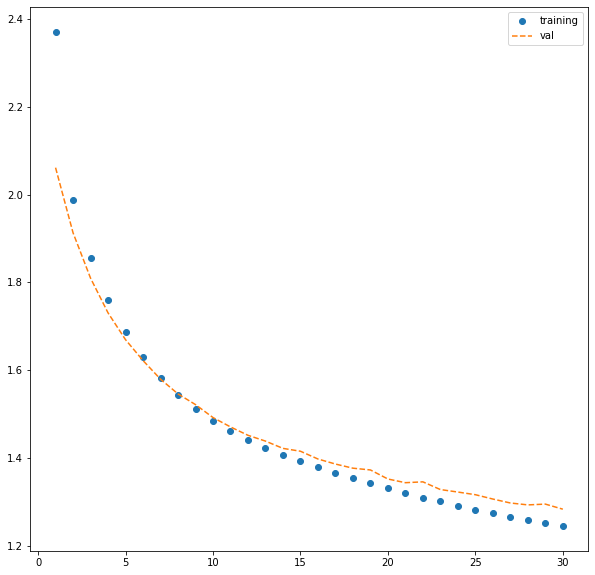

In [36]:
import matplotlib.pyplot as plt 

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

fig = plt.figure(figsize=(10,10))
epoch = range(1,len(loss_values)+1)
plt.plot(epoch,loss_values, 'o',label='training')
plt.plot(epoch,val_loss_values, '--',label='val')
plt.legend()
plt.show()

In [37]:
model.evaluate(X_test, y_test_categorical)

57/57 [==============================] - 0s 4ms/step - loss: 1.2853 - acc: 0.5350


[1.2853188514709473, 0.5350000262260437]

### ---- Análisis de resultados -----

## Con Dropout

El dropout es una técnica en modelamiento de redes neuronales para reducir el overfitting del modelo. Las redes neuronales tienden a hacer overfitting reduciendo su capacidad para predecir datos nuevos (no vistos por la red antes) a pesar de tener una alta afinadad con los de entrenamiento (como si los aprendiera).

1. Modelo

In [38]:
model2 = models.Sequential()
model2.add(layers.Dense(32, activation='relu', input_shape=(20000,)))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(6, activation='softmax')) # Se quiere predecir que categoría tiene mayor probabilidad

In [39]:
model2.compile(optimizer='rmsprop', # Versión optimizada del descenso del gradiente
              loss='categorical_crossentropy',
              metrics=['acc']   
             )

In [40]:
history2 = model2.fit(partial_x_train,
                   partial_y_train,
                   epochs=30,
                   batch_size=512,
                   validation_data=(x_val,y_val))

Epoch 1/30
13/13 [==============================] - 2s 52ms/step - loss: 1.7507 - acc: 0.3777 - val_loss: 1.6445 - val_acc: 0.4060
Epoch 2/30
13/13 [==============================] - 0s 25ms/step - loss: 1.6066 - acc: 0.4240 - val_loss: 1.5371 - val_acc: 0.4060
Epoch 3/30
13/13 [==============================] - 0s 26ms/step - loss: 1.5082 - acc: 0.4260 - val_loss: 1.4534 - val_acc: 0.4060
Epoch 4/30
13/13 [==============================] - 0s 26ms/step - loss: 1.4364 - acc: 0.4242 - val_loss: 1.3838 - val_acc: 0.4060
Epoch 5/30
13/13 [==============================] - 0s 27ms/step - loss: 1.3616 - acc: 0.4372 - val_loss: 1.3249 - val_acc: 0.4170
Epoch 6/30
13/13 [==============================] - 0s 27ms/step - loss: 1.2965 - acc: 0.4608 - val_loss: 1.2632 - val_acc: 0.4220
Epoch 7/30
13/13 [==============================] - 0s 25ms/step - loss: 1.2450 - acc: 0.4723 - val_loss: 1.2127 - val_acc: 0.4350
Epoch 8/30
13/13 [==============================] - 0s 26ms/step - loss: 1.1717 - a

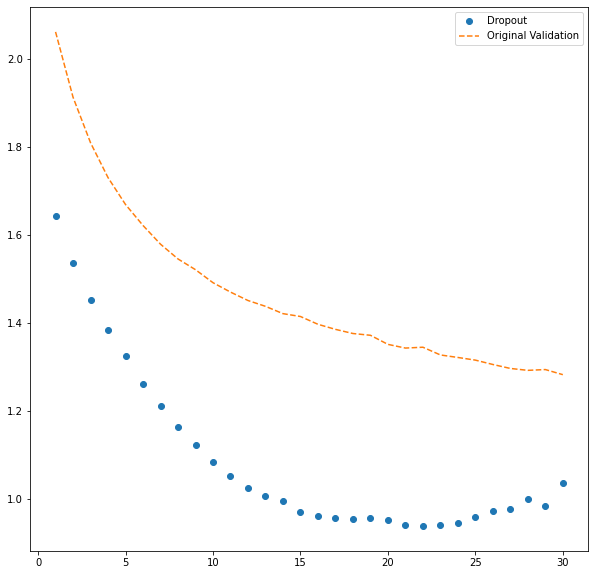

In [41]:
import matplotlib.pyplot as plt 

history_dict = history.history

val_loss_values = history_dict['val_loss']
val_loss_values2 = history2.history['val_loss']
loss_values = history_dict['loss']

fig = plt.figure(figsize=(10,10))
epoch = range(1,len(loss_values)+1)
plt.plot(epoch,val_loss_values2, 'o',label='Dropout')
plt.plot(epoch,val_loss_values, '--',label='Original Validation')
plt.legend()
plt.show()

### Análisis

Predicción del modelo con Dropout

In [42]:
y_pred = model2.predict(X_test) # Con X de test.
y_pred

array([[3.0150821e-07, 5.4111064e-07, 1.9008625e-06, 4.4070344e-05,
        4.5681912e-03, 9.9538499e-01],
       [8.7895454e-04, 3.6757821e-03, 4.9831700e-03, 8.2709067e-02,
        7.7550793e-01, 1.3224512e-01],
       [1.1953308e-02, 1.2466338e-01, 2.0078051e-01, 2.6165906e-01,
        2.1642958e-01, 1.8451415e-01],
       ...,
       [4.4476030e-07, 8.1362634e-07, 2.7113767e-06, 6.0302511e-05,
        5.5654352e-03, 9.9437028e-01],
       [2.4599228e-03, 1.4871879e-02, 2.2095939e-02, 1.2298089e-01,
        4.8233327e-01, 3.5525811e-01],
       [1.0144567e-04, 6.2899879e-04, 2.0397811e-03, 4.0271417e-03,
        2.3132883e-02, 9.7006971e-01]], dtype=float32)

Descategorizando *y predecido*

In [43]:
y_pred_uncat = []

for i in range( len(y_pred) ):
  y_pred_uncat.append( np.argmax(y_pred[i]) )

print(y_pred_uncat)

[5, 4, 3, 5, 4, 5, 1, 3, 5, 4, 1, 5, 4, 4, 4, 2, 4, 5, 2, 1, 1, 2, 5, 5, 4, 3, 5, 5, 5, 3, 3, 4, 4, 5, 5, 4, 5, 4, 3, 4, 5, 1, 5, 1, 4, 3, 4, 3, 4, 5, 5, 4, 4, 3, 5, 2, 2, 5, 5, 5, 5, 4, 3, 5, 5, 2, 1, 5, 3, 4, 4, 3, 5, 5, 5, 2, 5, 2, 5, 4, 2, 1, 1, 5, 3, 4, 4, 5, 5, 2, 5, 4, 4, 5, 5, 4, 4, 4, 5, 5, 4, 5, 5, 4, 1, 5, 4, 2, 4, 5, 5, 5, 4, 4, 5, 3, 5, 5, 4, 4, 5, 5, 5, 4, 5, 1, 4, 5, 4, 4, 5, 5, 5, 5, 1, 5, 4, 5, 5, 3, 4, 5, 4, 4, 5, 5, 1, 2, 5, 4, 5, 5, 5, 1, 4, 3, 5, 3, 5, 4, 4, 5, 5, 5, 2, 4, 5, 5, 5, 2, 5, 5, 4, 4, 5, 5, 5, 4, 5, 5, 5, 5, 2, 5, 4, 2, 5, 1, 2, 4, 5, 5, 5, 5, 5, 1, 5, 5, 4, 4, 4, 5, 5, 2, 5, 3, 5, 5, 5, 5, 3, 1, 5, 5, 4, 4, 4, 4, 5, 4, 5, 5, 5, 5, 5, 4, 4, 1, 3, 5, 2, 5, 5, 1, 5, 5, 5, 4, 5, 3, 5, 3, 1, 5, 5, 2, 5, 5, 5, 2, 4, 2, 2, 5, 5, 5, 2, 4, 5, 5, 5, 4, 4, 3, 2, 5, 4, 5, 2, 5, 5, 4, 5, 4, 5, 5, 5, 4, 5, 4, 1, 3, 5, 4, 5, 4, 4, 5, 1, 5, 4, 5, 5, 4, 4, 2, 5, 2, 4, 5, 5, 5, 1, 4, 5, 2, 2, 4, 5, 5, 5, 5, 4, 3, 4, 4, 5, 3, 4, 5, 5, 2, 3, 2, 5, 3, 5, 5, 4, 5, 5, 5, 5, 

Estandarizamos las salidas para que no tengan llaves diferentes

In [44]:
y_pred = pd.DataFrame(y_pred_uncat)
y_test_arr = np.array(y_test)
y_t = pd.DataFrame(y_test_arr)


In [45]:
confusion_matrix(y_pred, y_t) # Y predecido y Y_test estandarizados

array([[ 55,  16,   6,   1,   0],
       [ 63,  69,  34,  12,   2],
       [ 12,  36,  43,  24,   3],
       [  4,  28,  79, 252, 149],
       [  7,  19,  35, 246, 605]])

In [46]:
print(classification_report(y_pred,y_t)) # Y predecido y Y_test estandarizados

              precision    recall  f1-score   support

           1       0.39      0.71      0.50        78
           2       0.41      0.38      0.40       180
           3       0.22      0.36      0.27       118
           4       0.47      0.49      0.48       512
           5       0.80      0.66      0.72       912

    accuracy                           0.57      1800
   macro avg       0.46      0.52      0.48      1800
weighted avg       0.61      0.57      0.58      1800



### ---- Análisis de resultados -----